# GSE182158 Pseudobulk Analysis

This notebook breaks down the processing of single-cell RNA-seq data from GEO dataset GSE182158 into pseudobulk format. The analysis includes downloading data, processing 10x genomics files, and creating donor-level pseudobulk expression profiles.

## Overview
1. **Setup and Import Libraries** - Import dependencies and configure parameters
2. **Download and Extract GEO Data** - Fetch and extract supplementary files
3. **Process 10x Genomics Data** - Load and process matrix files
4. **Load Sample Metadata** - Parse GSM metadata and sample information
5. **Concatenate and Process AnnData Objects** - Combine samples with metadata
6. **Create Pseudobulk Data** - Group cells by donor and tissue
7. **Normalize and Transform Data** - Apply CPM normalization and log transformation
8. **Export Results** - Save processed data in multiple formats

In [ ]:
%pip install matplotlib seaborn scanpy scikit-learn plotly ipywidgets requests GEOparse

## 1. Setup and Import Libraries

First, let's import all necessary libraries and set up our configuration variables.

In [8]:
# Import required libraries
import argparse
import os
import re
import tarfile
import tempfile
import shutil
import gzip
import zipfile
from pathlib import Path
from typing import Dict, List, Tuple
from datetime import timedelta
import time

import numpy as np
import pandas as pd
import scipy.sparse as sp
import requests
from tqdm import tqdm

import scanpy as sc
import anndata as ad
import GEOparse
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress scanpy warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## 2. Comprehensive Raw Data Inventory & Expansion

The earlier quick scan returned zero 10x directories. This usually means one (or more) of:
- The raw supplementary tar was not extracted yet.
- Nested per-sample archives (tar/zip) inside the main tar still need expansion.
- Files are present in a flat layout and need reconstruction into proper 10x folders (matrix.mtx + barcodes + features/genes).
- `EXTRACT_ROOT` points to the wrong location.

Below we:
1. Locate and extract the raw master tar if needed.
2. Recursively expand any nested archives (`expand_nested_archives`).
3. Attempt reconstruction of flat 10x directories (`reconstruct_flat_10x_dirs`).
4. Build an inventory (directory tree + classification) for transparency.
5. Re-scan for 10x directories with both a lenient and strict heuristic.
6. Summarize counts for all discovered matrices.

Adjust the paths if your raw tar lives elsewhere.

In [9]:
import itertools

# Paths (edit if different)
OUTDIR = Path('./GSE182158_out')  # where the script would normally download
RAW_TAR = OUTDIR / 'GSE182158_RAW.tar'
WORK_ROOT = OUTDIR / 'raw_expanded'  # workspace for extracted content
WORK_ROOT.mkdir(exist_ok=True, parents=True)

# Utilities adapted from original script (idempotent safe)

def extract_master_tar(tar_path: Path, dest: Path):
    if not tar_path.exists():
        print(f"[error] Master tar not found at {tar_path}. Place it there or update RAW_TAR path.")
        return
    # Detect whether already extracted (heuristic: presence of any *.mtx* under dest)
    if any(dest.rglob('matrix.mtx')) or any(dest.rglob('matrix.mtx.gz')):
        print('[info] Master tar appears already extracted (matrix files found); skipping re-extract.')
        return
    print(f"[extract] Extracting {tar_path} -> {dest}")
    with tarfile.open(tar_path, 'r:*') as t:
        t.extractall(dest)

# Reuse expand_nested_archives logic (simplified to avoid duplication if already imported)

def expand_nested_archives(root: Path):
    changed = True
    round_no = 0
    while changed:
        round_no += 1
        changed = False
        archives = [p for p in root.rglob('*') if p.is_file()]
        for p in archives:
            name = p.name.lower()
            try:
                if (name.endswith('.tar') or name.endswith('.tar.gz') or name.endswith('.tgz') or
                    name.endswith('.tar.bz2') or name.endswith('.tar.xz')) and tarfile.is_tarfile(p):
                    target_dir = p.parent / (p.stem.replace('.tar',''))
                    if not target_dir.exists() or not any(target_dir.iterdir()):
                        target_dir.mkdir(exist_ok=True)
                        with tarfile.open(p, 'r:*') as t:
                            t.extractall(target_dir)
                        changed = True
                elif name.endswith('.zip') and zipfile.is_zipfile(p):
                    target_dir = p.parent / p.stem
                    if not target_dir.exists():
                        target_dir.mkdir()
                        with zipfile.ZipFile(p) as z:
                            z.extractall(target_dir)
                        changed = True
            except Exception as e:
                print(f"[warn] Could not extract nested {p}: {e}")
        if changed:
            print(f"[expand] Completed round {round_no}, scanning again...")

# Reconstruction from flat pattern (adapting earlier function)

def reconstruct_flat_10x_dirs(root: Path) -> List[Path]:
    created = []
    # Search for all matrix files in the root directory
    mtx_candidates = list(root.glob('*_matrix.mtx.gz')) + list(root.glob('*_matrix.mtx'))
    
    for mtx_path in mtx_candidates:
        prefix = mtx_path.name.split('_matrix.mtx')[0]
        base_dir = mtx_path.parent
        
        # Find corresponding barcodes and genes/features files in the same directory
        barcodes_path = next(base_dir.glob(f'{prefix}_barcodes.tsv*'), None)
        # Prioritize features.tsv, fall back to genes.tsv
        features_path = next(base_dir.glob(f'{prefix}_features.tsv*'), None)
        if not features_path:
            features_path = next(base_dir.glob(f'{prefix}_genes.tsv*'), None)

        if not (barcodes_path and features_path):
            print(f"[warn] Skipping {prefix}: missing barcodes or features/genes file.")
            continue

        target_dir = base_dir / f'{prefix}_repacked'
        target_dir.mkdir(exist_ok=True)

        # Standardize filenames and copy
        shutil.copy2(mtx_path, target_dir / ('matrix.mtx.gz' if mtx_path.name.endswith('.gz') else 'matrix.mtx'))
        shutil.copy2(barcodes_path, target_dir / ('barcodes.tsv.gz'if barcodes_path.name.endswith('.gz') else 'barcodes.tsv'))
        
        # If the feature file is `genes.tsv`, it needs to be converted to `features.tsv`
        is_gz = features_path.name.endswith('.gz')
        if 'genes.tsv' in features_path.name:
            dest_feat_path = target_dir / ('features.tsv.gz' if is_gz else 'features.tsv')
            opener_in = gzip.open if is_gz else open
            opener_out = gzip.open if is_gz else open
            with opener_in(features_path, 'rt') as fin, opener_out(dest_feat_path, 'wt') as fout:
                for line in fin:
                    parts = line.strip().split('\t')
                    # Create a valid 3-column features file
                    if len(parts) == 1: # Only gene ID
                        fout.write(f"{parts[0]}\t{parts[0]}\tGene Expression\n")
                    elif len(parts) >= 2: # Gene ID and Symbol
                        fout.write(f"{parts[0]}\t{parts[1]}\tGene Expression\n")
        else: # It's already a features file, just copy it
            dest_feat_path = target_dir / ('features.tsv.gz' if is_gz else 'features.tsv')
            shutil.copy2(features_path, dest_feat_path)
            
        created.append(target_dir)
        
    return created

# Strict verification

def verify_10x_dir(dir_path: Path) -> bool:
    if not dir_path.is_dir():
        return False
    files = {f.name for f in dir_path.iterdir() if f.is_file()}
    return (any(f.startswith('matrix.mtx') for f in files) and
            any(f.startswith('barcodes.tsv') for f in files) and
            any(f.startswith('features.tsv') for f in files))

# Directory tree inventory

def inventory_tree(root: Path, max_depth: int = 5, max_entries: int = 2000):
    rows = []
    for p in root.rglob('*'):
        if len(rows) >= max_entries:
            break
        rel = p.relative_to(root)
        depth = len(rel.parts)
        if depth > max_depth:
            continue
        rows.append({
            'path': str(rel),
            'is_dir': p.is_dir(),
            'size': p.stat().st_size if p.is_file() else None
        })
    return pd.DataFrame(rows)


# 1. Extract master tar if needed
extract_master_tar(RAW_TAR, WORK_ROOT)

# 2. Expand nested archives
expand_nested_archives(WORK_ROOT)

# 3. Attempt reconstruction (harmless if nothing to do)
created_dirs = reconstruct_flat_10x_dirs(WORK_ROOT)
print(f"[reconstruct] Created/verified {len(created_dirs)} repacked directories")

# 4. Inventory tree
inv_df = inventory_tree(WORK_ROOT, max_depth=6, max_entries=4000)
print(f"[inventory] Listed {len(inv_df)} entries (showing head)")
inv_df.head()

[info] Master tar appears already extracted (matrix files found); skipping re-extract.
[reconstruct] Created/verified 11 repacked directories
[inventory] Listed 77 entries (showing head)
[reconstruct] Created/verified 11 repacked directories
[inventory] Listed 77 entries (showing head)


,path,is_dir,size
0,GSM5519460_B02_genes.tsv.gz,False,264787.0
1,GSM5519464_A01_matrix.mtx.gz,False,235198222.0
2,GSM5519466_A03_repacked,True,NaN
3,GSM5519463_U02_matrix.mtx.gz,False,132799510.0
4,GSM5519466_A03_barcodes.tsv.gz,False,43927.0


### 2a. List Column Structures in Raw Flat 10x Files
We now add a function to summarize the inferred column layout of every *_genes.tsv*, *_features.tsv*, *_barcodes.tsv* and *_matrix.mtx* file under `WORK_ROOT`. This helps confirm consistency before downstream processing.

In [10]:
# Helper functions (enhanced) – imports already done earlier

def infer_tsv_columns(sample_line: str, kind: str):
    n_tabs = sample_line.count('\t')
    n_cols = n_tabs + 1
    if kind == 'genes' and n_cols >= 2:
        return ['gene_id', 'gene_symbol'][:n_cols]
    if kind == 'features':
        base = ['gene_id', 'gene_symbol', 'feature_type', 'genome']
        return base[:n_cols]
    if kind == 'barcodes':
        return ['barcode']
    return [f'col{i+1}' for i in range(n_cols)]

def first_data_line(path: Path):
    opener = gzip.open if path.suffix == '.gz' else open
    try:
        with opener(path, 'rt') as fh:
            for line in fh:
                if line.strip() and not line.startswith('%'):
                    return line.rstrip('\n')
    except Exception:
        return None
    return None

def parse_matrix_header(path: Path):
    opener = gzip.open if path.suffix == '.gz' else open
    with opener(path, 'rt') as fh:
        for line in fh:
            if line.startswith('%'):
                continue
            parts = line.strip().split()
            if len(parts) == 3 and all(p.isdigit() for p in parts):
                return tuple(map(int, parts))
    return None

def count_nonempty_lines(path: Path, limit: int = None) -> int:
    opener = gzip.open if path.suffix == '.gz' else open
    n = 0
    with opener(path, 'rt') as fh:
        for i, line in enumerate(fh):
            if line.strip():
                n += 1
            if limit and i >= limit:
                break
    return n

def list_flat_file_column_structures_with_counts(root: Path) -> pd.DataFrame:
    patterns = [
        '*_genes.tsv','*_genes.tsv.gz','*_features.tsv','*_features.tsv.gz',
        '*_barcodes.tsv','*_barcodes.tsv.gz','*_matrix.mtx','*_matrix.mtx.gz'
    ]
    rows = []
    for pat in patterns:
        for f in root.glob(pat):
            kind = ('genes' if '_genes.tsv' in f.name else
                    'features' if '_features.tsv' in f.name else
                    'barcodes' if '_barcodes.tsv' in f.name else
                    'matrix')
            entry = {'file': str(f.relative_to(root)), 'kind': kind}
            if kind == 'matrix':
                dims = parse_matrix_header(f)
                if dims:
                    entry.update({'n_rows': dims[0], 'n_cols': dims[1], 'nnz': dims[2]})
            else:
                sample = first_data_line(f)
                if sample:
                    cols = infer_tsv_columns(sample, kind)
                    entry['n_inferred_cols'] = len(cols)
                    entry['inferred_cols'] = ','.join(cols)
                else:
                    entry['n_inferred_cols'] = None
                    entry['inferred_cols'] = None
                entry['n_lines'] = count_nonempty_lines(f)
            rows.append(entry)
    return pd.DataFrame(rows).sort_values('file')

#print the head of the result
file_struct_counts_df = list_flat_file_column_structures_with_counts(WORK_ROOT)
print(f"Found {len(file_struct_counts_df)} files (with line counts)")
file_struct_counts_df.head(20)


Found 33 files (with line counts)


,file,kind,n_inferred_cols,inferred_cols,n_lines,n_rows,n_cols,nnz
14,GSM5519456_D01_barcodes.tsv.gz,barcodes,1.0,barcode,9039.0,NaN,NaN,NaN
1,GSM5519456_D01_genes.tsv.gz,genes,2.0,"gene_id,gene_symbol",33694.0,NaN,NaN,NaN
28,GSM5519456_D01_matrix.mtx.gz,matrix,NaN,NaN,NaN,33694.0,9039.0,35832539.0
18,GSM5519457_D02_barcodes.tsv.gz,barcodes,1.0,barcode,11000.0,NaN,NaN,NaN
6,GSM5519457_D02_genes.tsv.gz,genes,2.0,"gene_id,gene_symbol",33694.0,NaN,NaN,NaN
29,GSM5519457_D02_matrix.mtx.gz,matrix,NaN,NaN,NaN,33694.0,11000.0,12572635.0
19,GSM5519458_D03_barcodes.tsv.gz,barcodes,1.0,barcode,11022.0,NaN,NaN,NaN
7,GSM5519458_D03_genes.tsv.gz,genes,2.0,"gene_id,gene_symbol",33694.0,NaN,NaN,NaN
32,GSM5519458_D03_matrix.mtx.gz,matrix,NaN,NaN,NaN,33694.0,11022.0,36023552.0
12,GSM5519459_B01_barcodes.tsv.gz,barcodes,1.0,barcode,15183.0,NaN,NaN,NaN


### 2b. Compute and Visualize QC Metrics
This function calculates standard QC metrics for each sample (AnnData object). It then generates violin plots to visualize the distribution of total UMI counts per cell and the number of genes detected per cell, which are crucial for identifying low-quality cells.

In [11]:
def compute_and_plot_qc(adatas: List[ad.AnnData], sample_names: List[str]):
    """
    Compute QC metrics and plot distributions for total counts and n_genes_by_counts.

    Args:
        adatas: A list of AnnData objects, one for each sample.
        sample_names: A list of sample names corresponding to the AnnData objects.
    """
    if not adatas:
        print("[warning] No AnnData objects provided; skipping QC.")
        return

    print("[info] Computing and plotting QC metrics...")

    # 1. Calculate QC metrics for each AnnData object
    for i, adata in enumerate(adatas):
        # Make var names unique
        adata.var_names_make_unique()
        # Calculate QC
        sc.pp.calculate_qc_metrics(adata, inplace=True)
        adata.obs['sample'] = sample_names[i]

    # 2. Concatenate for plotting
    combined_adata = ad.concat(adatas, label="sample_id")

    # 3. Create plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot total_counts
    sns.violinplot(x='sample', y='total_counts', data=combined_adata.obs, ax=axes[0])
    axes[0].set_title('Total Counts (UMIs) per Cell')
    axes[0].set_ylabel('Total Counts')
    axes[0].set_xlabel('Sample')
    axes[0].tick_params(axis='x', rotation=90)

    # Plot n_genes_by_counts
    sns.violinplot(x='sample', y='n_genes_by_counts', data=combined_adata.obs, ax=axes[1])
    axes[1].set_title('Number of Genes per Cell')
    axes[1].set_ylabel('Number of Genes')
    axes[1].set_xlabel('Sample')
    axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

# Placeholder for calling the function.
# This will be used later in the notebook once the AnnData objects are loaded.
# For now, we define a dummy list to demonstrate.
# Example usage (replace with actual data later):
# adatas_list = [...] 
# sample_names_list = [...]
# compute_and_plot_qc(adatas_list, sample_names_list)

print("QC function `compute_and_plot_qc` is defined and ready to be used.")
# Since we don't have the data loaded into AnnData objects yet, we will not call the function.
# The function will be called in a subsequent step.

QC function `compute_and_plot_qc` is defined and ready to be used.


## 3. Load 10x Data and Run Initial QC

Now that we have located and prepared the raw data directories, we will load each valid 10x sample directory into an `AnnData` object using `scanpy`. Once loaded, we will immediately pass them to our `compute_and_plot_qc` function to visualize the initial quality of the single-cell data.

[info] Searching for valid 10x directories in GSE182158_out/raw_expanded...
[info] Found 11 valid 10x directories.


Loading 10x data:   9%|▉         | 1/11 [00:00<00:08,  1.20it/s]

  -> Loaded 'GSM5519456_D01' with 9039 cells and 33694 genes.


Loading 10x data:  18%|█▊        | 2/11 [00:01<00:05,  1.74it/s]

  -> Loaded 'GSM5519457_D02' with 11000 cells and 33694 genes.


Loading 10x data:  27%|██▋       | 3/11 [00:02<00:05,  1.46it/s]

  -> Loaded 'GSM5519458_D03' with 11022 cells and 33694 genes.


Loading 10x data:  36%|███▋      | 4/11 [00:03<00:06,  1.15it/s]

  -> Loaded 'GSM5519459_B01' with 15183 cells and 33694 genes.


Loading 10x data:  45%|████▌     | 5/11 [00:04<00:05,  1.10it/s]

  -> Loaded 'GSM5519460_B02' with 13732 cells and 33694 genes.


Loading 10x data:  55%|█████▍    | 6/11 [00:04<00:04,  1.16it/s]

  -> Loaded 'GSM5519461_B03' with 10525 cells and 33694 genes.


Loading 10x data:  64%|██████▎   | 7/11 [00:06<00:03,  1.03it/s]

  -> Loaded 'GSM5519462_U01' with 12740 cells and 33694 genes.


Loading 10x data:  73%|███████▎  | 8/11 [00:07<00:02,  1.04it/s]

  -> Loaded 'GSM5519463_U02' with 9861 cells and 33694 genes.


Loading 10x data:  82%|████████▏ | 9/11 [00:09<00:02,  1.31s/it]

  -> Loaded 'GSM5519464_A01' with 24246 cells and 33694 genes.


Loading 10x data:  91%|█████████ | 10/11 [00:10<00:01,  1.32s/it]

  -> Loaded 'GSM5519465_A02' with 17825 cells and 33694 genes.


Loading 10x data: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]

  -> Loaded 'GSM5519466_A03' with 11253 cells and 33694 genes.
[info] Computing and plotting QC metrics...


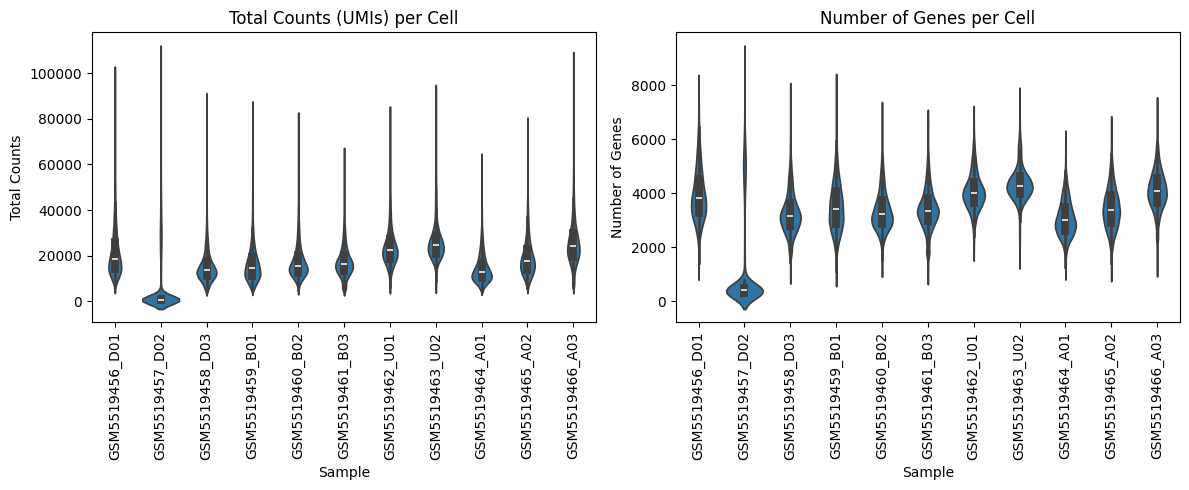

In [12]:
def find_10x_directories(root: Path) -> List[Path]:
    """Finds all valid 10x directories within a given root directory."""
    print(f"[info] Searching for valid 10x directories in {root}...")
    valid_dirs = [d for d in root.iterdir() if d.is_dir() and verify_10x_dir(d)]
    # Also check one level deeper for structures like root/sample_name/matrix_files
    for d in root.iterdir():
        if d.is_dir():
            for sub_d in d.iterdir():
                 if sub_d.is_dir() and verify_10x_dir(sub_d):
                    valid_dirs.append(sub_d)
    
    # Include repacked directories from the previous step
    repacked_dirs = list(root.glob('*_repacked'))
    for d in repacked_dirs:
        if d.is_dir() and verify_10x_dir(d) and d not in valid_dirs:
            valid_dirs.append(d)
            
    print(f"[info] Found {len(valid_dirs)} valid 10x directories.")
    return sorted(list(set(valid_dirs)))

def load_10x_data(tenx_dirs: List[Path]) -> Tuple[List[ad.AnnData], List[str]]:
    """Loads a list of 10x directories into AnnData objects."""
    adatas = []
    sample_names = []
    
    for path in tqdm(tenx_dirs, desc="Loading 10x data"):
        try:
            # Extract a clean sample name from the directory path
            sample_name = path.name.replace('_repacked', '').replace('_filtered_feature_bc_matrix', '')
            
            # Load the data
            adata = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
            adatas.append(adata)
            sample_names.append(sample_name)
            print(f"  -> Loaded '{sample_name}' with {adata.n_obs} cells and {adata.n_vars} genes.")
        except Exception as e:
            print(f"[error] Failed to load {path}: {e}")
            
    return adatas, sample_names

# 1. Find all valid 10x directories in our working root
tenx_directories = find_10x_directories(WORK_ROOT)

# 2. Load the data from these directories
adatas_list, sample_names_list = load_10x_data(tenx_directories)

# 3. Compute and plot QC metrics using the loaded data
if adatas_list:
    compute_and_plot_qc(adatas_list, sample_names_list)
else:
    print("[warning] No data was loaded, so QC plotting is skipped.")

## 4. QC, Clustering, and Annotation

This new section performs a complete analysis pipeline on the loaded single-cell data. The steps include:
1.  **Mitochondrial QC**: Calculate the percentage of mitochondrial reads for each cell.
2.  **Filtering**: Apply simple, permissive filters based on gene counts, UMI counts, and mitochondrial DNA content.
3.  **Preprocessing**: Normalize the data, apply a log transformation, and identify highly variable genes (HVGs).
4.  **Dimensionality Reduction**: Run PCA and compute a UMAP embedding.
5.  **Clustering**: Use the Leiden algorithm to find cell clusters.
6.  **Tissue Annotation**: Parse sample names to annotate cells by their tissue of origin (Adipose, Bone Marrow, Dermis, Umbilical).
7.  **Marker Gene Analysis**: Find and export marker genes for each cluster.
8.  **Manual Annotation**: Assign cell type labels to clusters based on canonical markers.
9.  **Visualization**: Generate UMAPs colored by cluster, tissue, and cell type label, plus a dot plot of marker genes.
10. **Export**: Save the final, annotated AnnData object.


Combined AnnData object created with 146426 cells and 33694 genes.
Initial state: 146426 cells, 33694 genes.
Initial state: 146426 cells, 33694 genes.
After filtering: 142064 cells, 29760 genes remain.
After filtering: 142064 cells, 29760 genes remain.


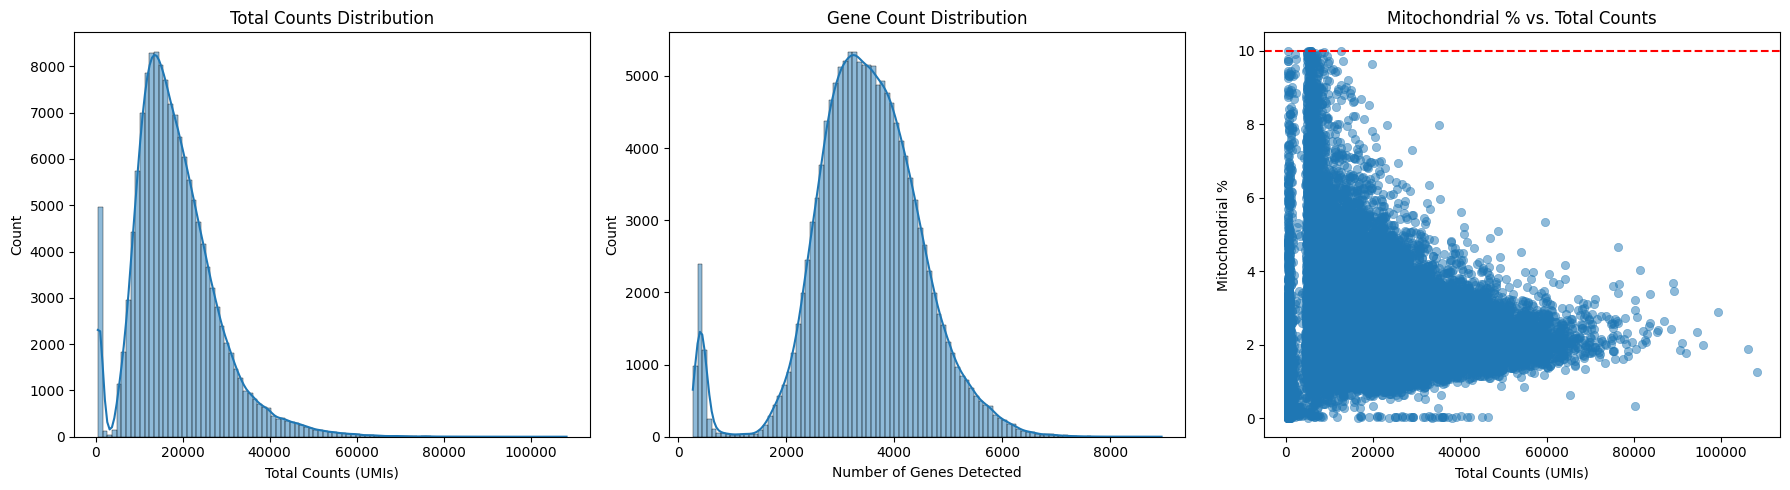

In [13]:
# Combine all samples into a single AnnData object
if 'adatas_list' in locals() and adatas_list:
    adata = ad.concat(adatas_list, label="sample", index_unique="-")
    print(f"Combined AnnData object created with {adata.n_obs} cells and {adata.n_vars} genes.")
else:
    print("[error] `adatas_list` not found. Please run previous cells to load data.")

# --- 1. QC and Filtering ---
if 'adata' in locals():
    # Make variable names unique
    adata.var_names_make_unique()

    # --- Mitochondrial Gene Calculation ---
    # Identify mitochondrial genes (works for both 'MT-' and 'mt-')
    adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    # --- Filtering ---
    print(f"Initial state: {adata.n_obs} cells, {adata.n_vars} genes.")
    
    # Store raw counts for later
    adata.layers['counts'] = adata.X.copy()

    # Define filtering thresholds
    min_genes_per_cell = 200
    min_counts_per_cell = 500
    mt_cutoff = 10.0  # Max mitochondrial percentage
    min_cells_per_gene = 3

    # Apply filters
    sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
    sc.pp.filter_cells(adata, min_counts=min_counts_per_cell)
    adata = adata[adata.obs.pct_counts_mt < mt_cutoff, :]
    sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

    print(f"After filtering: {adata.n_obs} cells, {adata.n_vars} genes remain.")
    
    # --- QC Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    sns.histplot(adata.obs['total_counts'], bins=100, ax=axes[0], kde=True)
    axes[0].set_title('Total Counts Distribution')
    axes[0].set_xlabel('Total Counts (UMIs)')
    
    sns.histplot(adata.obs['n_genes_by_counts'], bins=100, ax=axes[1], kde=True)
    axes[1].set_title('Gene Count Distribution')
    axes[1].set_xlabel('Number of Genes Detected')

    sns.scatterplot(data=adata.obs, x='total_counts', y='pct_counts_mt', alpha=0.5, ax=axes[2], edgecolor=None)
    axes[2].set_title('Mitochondrial % vs. Total Counts')
    axes[2].axhline(mt_cutoff, color='red', linestyle='--')
    axes[2].set_xlabel('Total Counts (UMIs)')
    axes[2].set_ylabel('Mitochondrial %')
    
    plt.tight_layout()
    plt.show()


In [ ]:
%pip install scikit-misc


In [ ]:
%pip install leidenalg python-igraph

<Figure size 800x600 with 0 Axes>

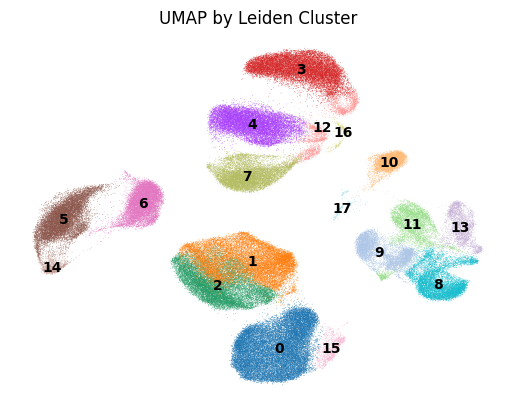

In [18]:
# --- 2. Preprocessing, Dimensionality Reduction, and Clustering ---
if 'adata' in locals():
    # --- Normalization and HVG Selection ---
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3', subset=True)

    # --- PCA and UMAP ---
    sc.tl.pca(adata, n_comps=50, use_highly_variable=True)
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
    sc.tl.leiden(adata, resolution=0.6, key_added="leiden_clusters")
    sc.tl.umap(adata)

    # --- Visualization: UMAP by Cluster ID ---
    plt.figure(figsize=(8, 6))
    sc.pl.umap(adata, color='leiden_clusters', legend_loc='on data', 
               title='UMAP by Leiden Cluster', show=False, frameon=False)
    plt.show()


Tissue annotation complete. Unique tissue names found:
['Dermis' 'Bone marrow' 'Umbilical' 'Adipose']


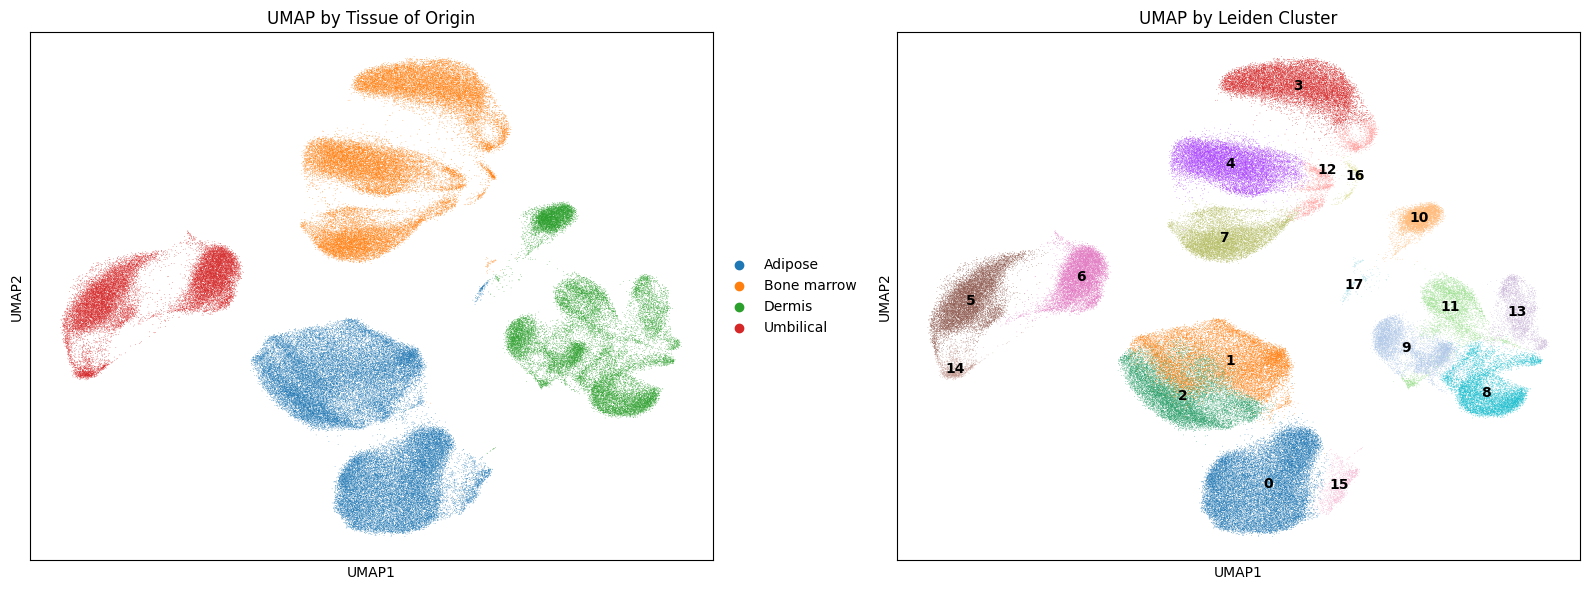

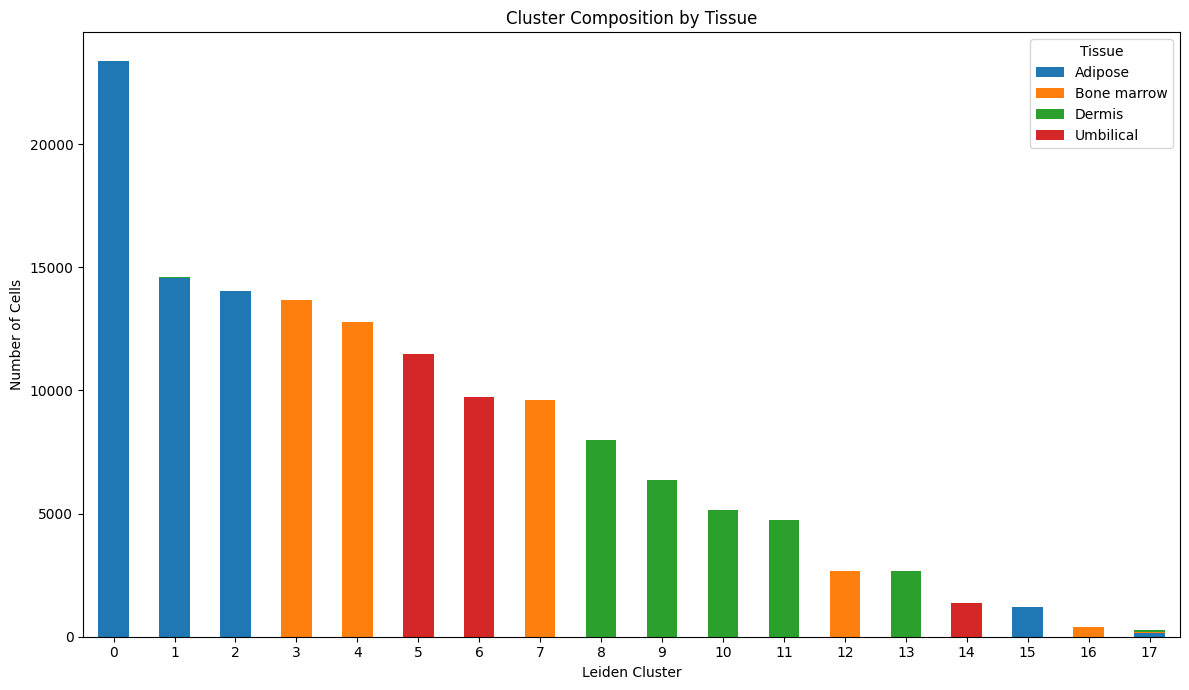

In [29]:
# --- 3. Tissue Annotation from Sample IDs ---
if 'adata' in locals():
    # --- Define Tissue Mapping ---
    # Option B: Remap integer labels from concatenation to the true sample codes.
    # This is necessary because `ad.concat` with a `label` creates a categorical
    # series (0, 1, 2, ...) which overwrites the original sample names.
    
    # We must ensure this mapping corresponds to the order of concatenation.
    # You can verify the order by inspecting `sample_names_list` from the loading step.
    int_to_code = {
      "0": "D01", "1": "D02", "2": "D03",
      "3": "B01", "4": "B02", "5": "B03",
      "6": "U01", "7": "U02",
      "8": "A01", "9": "A02", "10": "A03",
    }

    # The 'sample' column currently holds integer-like strings ('0', '1', etc.)
    adata.obs['sample_code'] = adata.obs['sample'].astype(str).map(int_to_code).fillna('Unknown')
    
    # Extract the first letter to determine tissue type
    adata.obs['tissue_letter'] = adata.obs['sample_code'].str[0]
    
    tissue_map = {
        'A': 'Adipose',
        'B': 'Bone marrow',
        'D': 'Dermis',
        'U': 'Umbilical'
    }
    adata.obs['tissue_name'] = adata.obs['tissue_letter'].map(tissue_map).fillna('Unknown')

    print("Tissue annotation complete. Unique tissue names found:")
    print(adata.obs['tissue_name'].unique())

    # --- Visualization: UMAP by Tissue and Cluster ---
    # Create two side-by-side plots for comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: UMAP by Tissue of Origin
    sc.pl.umap(adata, color='tissue_name', title='UMAP by Tissue of Origin', ax=axes[0], show=False)

    # Plot 2: UMAP by Leiden Cluster with numbers on the clusters
    sc.pl.umap(adata, color='leiden_clusters', title='UMAP by Leiden Cluster', legend_loc='on data', ax=axes[1], show=False)

    plt.tight_layout()
    plt.show()


    # --- Optional: Stacked Bar Plot of Cluster Composition ---
    cluster_tissue_counts = pd.crosstab(adata.obs['leiden_clusters'], adata.obs['tissue_name'])
    cluster_tissue_counts.plot(kind='bar', stacked=True, figsize=(12, 7),
                               title='Cluster Composition by Tissue')
    plt.ylabel('Number of Cells')
    plt.xlabel('Leiden Cluster')
    plt.xticks(rotation=0)
    plt.legend(title='Tissue')
    plt.tight_layout()
    plt.show()


Top marker genes saved to 'top_markers_per_cluster.csv'

Top 5 marker genes per cluster:


,cluster,gene,log2FC,p_adj,scores
0,0,TAGLN2,0.848300,0.000000e+00,196.015961
1,0,H2AFZ,0.745235,0.000000e+00,192.583588
2,0,PHLDA2,2.359973,0.000000e+00,190.640930
3,0,SPHK1,2.702029,0.000000e+00,186.812469
4,0,KRT7,4.283794,0.000000e+00,185.968353
...,...,...,...,...,...
51000,17,SH3BGRL3,0.792642,2.280829e-149,26.335106
51001,17,PKM,0.710444,5.635215e-146,26.010607
51002,17,TPI1,0.632476,2.604619e-140,25.489088
51003,17,CD59,0.784118,2.110319e-139,25.395695



Genes displayed on the dot plot x-axis:
['TAGLN2', 'H2AFZ', 'PHLDA2', 'SPHK1', 'KRT7', 'POSTN', 'OLFM2', 'CYCS', 'SRM', 'IL13RA2', 'CHI3L1', 'MFAP5', 'LMO4', 'S100A16', 'ITGBL1', 'FN1', 'ENAH', 'CDH11', 'COL12A1', 'HLA-DRA', 'CD74', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DMA', 'KRT8', 'KRT18', 'UCHL1', 'NRP2', 'LMCD1', 'TGM2', 'RBP1', 'MATN2', 'QPRT', 'CRISPLD2', 'VMO1', 'IGFBP4', 'GALNT1', 'LEPR', 'SRGN', 'TWIST2', 'CTSK', 'CRABP2', 'OSR2', 'NBL1', 'IFI6', 'CFD', 'C1S', 'MFAP4', 'S100A4', 'TAGLN', 'ACTA2', 'DCN', 'RPS4Y1', 'ABI3BP', 'NR2F2', 'IFI27', 'FBN1', 'CENPF', 'MKI67', 'NUSAP1', 'PRC1', 'TPX2', 'LMOD1', 'MYLK', 'LAMC1', 'TINAGL1', 'UBE2C', 'RRM2', 'PPP1R14A', 'CRYAB', 'ARHGDIB', 'MYL9', 'HSP90B1', 'SERPINE2', 'MT-ND3', 'APLP2', 'SH3BGRL3', 'PKM', 'TPI1', 'CD59', 'MYL12A']


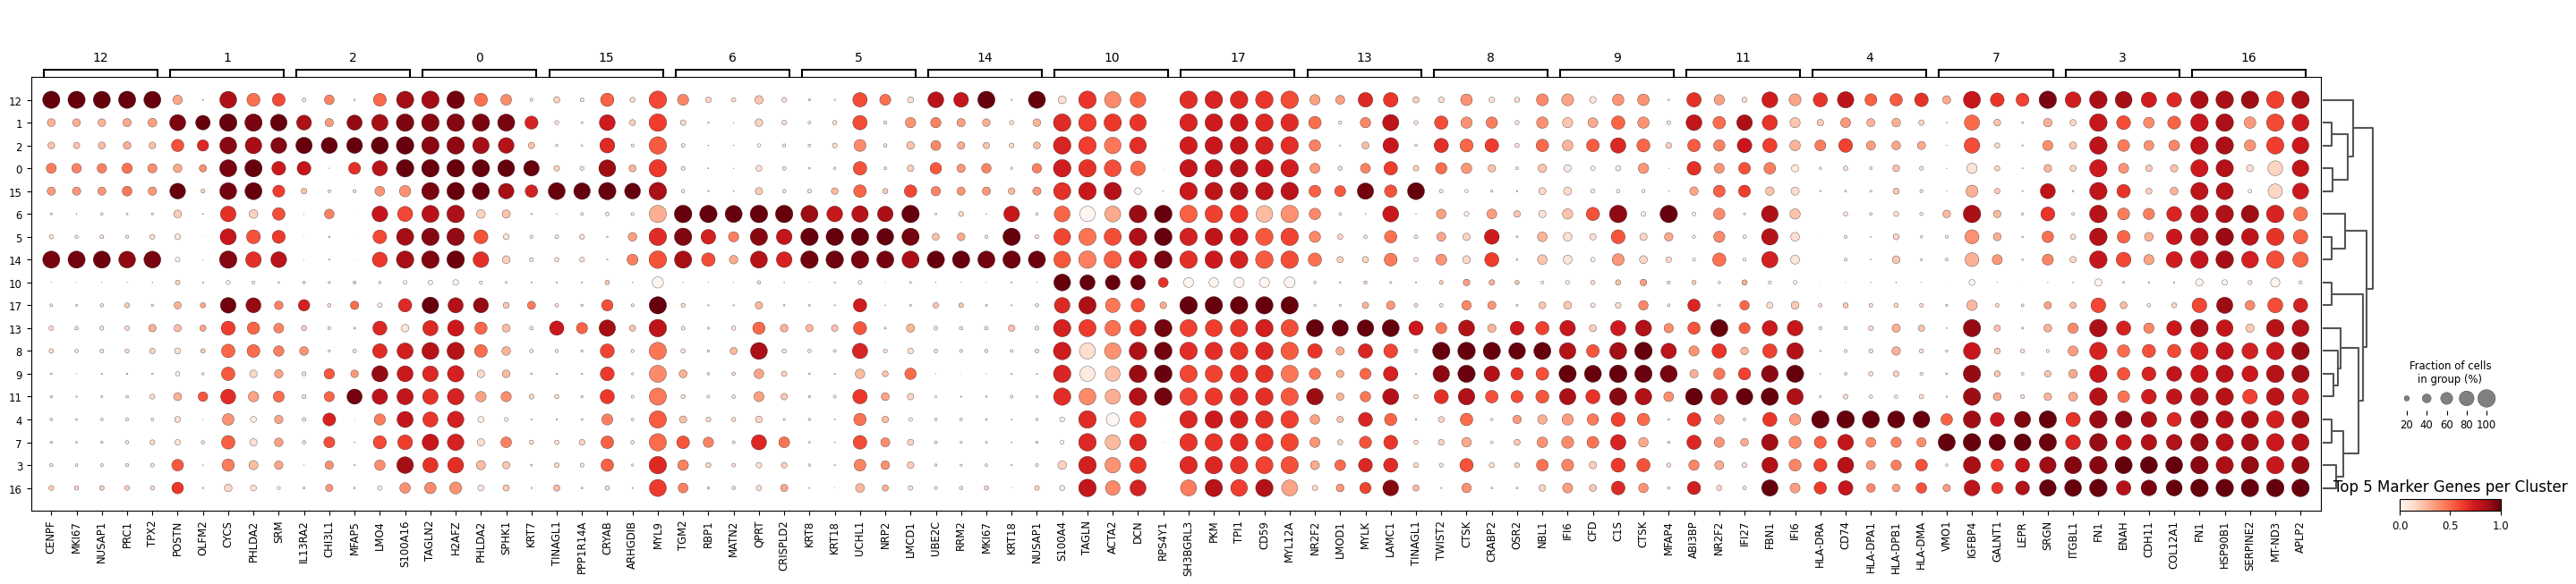

In [32]:
# --- 4. Marker Gene Analysis ---
if 'adata' in locals():
    # --- Find Marker Genes using Wilcoxon Rank-Sum Test ---
    sc.tl.rank_genes_groups(adata, 'leiden_clusters', method='wilcoxon')

    # --- Extract and Save Top Markers to CSV ---
    marker_results = adata.uns['rank_genes_groups']
    groups = marker_results['names'].dtype.names
    
    # Create a DataFrame to hold all markers
    all_markers_df = pd.DataFrame()

    for group in groups:
        # Extract data for the current cluster
        markers = sc.get.rank_genes_groups_df(adata, group=group)
        markers['cluster'] = group
        all_markers_df = pd.concat([all_markers_df, markers], ignore_index=True)

    # Select and rename columns for clarity
    top_markers_df = all_markers_df[['cluster', 'names', 'logfoldchanges', 'pvals_adj', 'scores']]
    top_markers_df.rename(columns={
        'names': 'gene',
        'logfoldchanges': 'log2FC',
        'pvals_adj': 'p_adj'
    }, inplace=True)

    # Save to CSV
    marker_filename = 'top_markers_per_cluster.csv'
    top_markers_df.to_csv(marker_filename, index=False)
    print(f"Top marker genes saved to '{marker_filename}'")

    # --- Display Top Markers Table ---
    print("\nTop 5 marker genes per cluster:")
    display(top_markers_df.groupby('cluster').head(5))

    # --- Get and print genes from the dot plot's x-axis ---
    n_genes_in_plot = 5  # Corresponds to n_genes in the dotplot
    
    # Collect top N genes from each cluster
    plot_genes_list = []
    for group in groups:
        # Get the top N gene names for the cluster
        top_genes = marker_results['names'][group][:n_genes_in_plot]
        plot_genes_list.extend(top_genes)
        
    # Create a unique list of genes while preserving order
    unique_plot_genes = list(dict.fromkeys(plot_genes_list))
    
    print("\nGenes displayed on the dot plot x-axis:")
    print(unique_plot_genes)

    # --- Visualize Top Markers with a Dot Plot ---
    sc.pl.rank_genes_groups_dotplot(adata, n_genes=n_genes_in_plot, groupby='leiden_clusters', 
                                    standard_scale='var', show=False)
    plt.title(f'Top {n_genes_in_plot} Marker Genes per Cluster')
    plt.show()


Top marker genes per tissue saved to 'top_markers_per_tissue.csv'

Top 5 marker genes per tissue:


,tissue,gene,log2FC,p_adj,scores
0,Adipose,PHLDA2,3.014595,0.0,271.665771
1,Adipose,TNFRSF12A,2.271125,0.0,267.961517
2,Adipose,SPHK1,3.485411,0.0,257.992554
3,Adipose,SERPINE1,3.494539,0.0,251.079010
4,Adipose,CYCS,1.618889,0.0,243.493301
3000,Bone marrow,FHL2,1.658871,0.0,259.318268
3001,Bone marrow,SRGN,3.312823,0.0,252.602097
3002,Bone marrow,FN1,0.559446,0.0,249.020126
3003,Bone marrow,CD74,4.098874,0.0,245.807892
3004,Bone marrow,LEPR,6.400347,0.0,242.548203



Genes displayed on the tissue dot plot x-axis:
['PHLDA2', 'TNFRSF12A', 'SPHK1', 'SERPINE1', 'CYCS', 'FHL2', 'SRGN', 'FN1', 'CD74', 'LEPR', 'RPS4Y1', 'CTSK', 'DCN', 'S100A4', 'GPNMB', 'KRT8', 'TGM2', 'KRT18', 'LMCD1', 'QPRT']


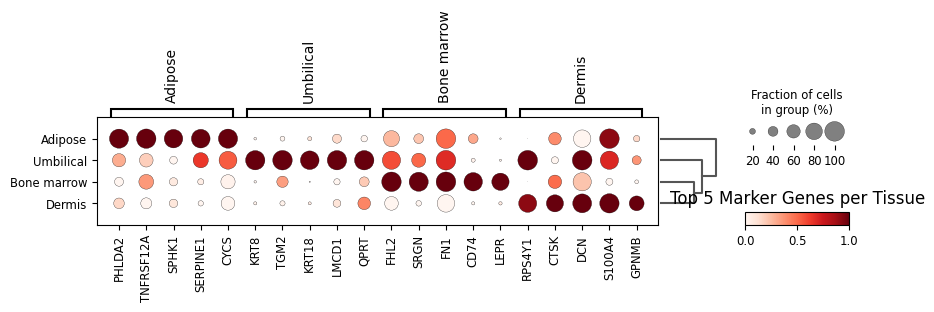

In [35]:
# --- 4b. Marker Gene Analysis per Tissue ---
if 'adata' in locals() and 'tissue_name' in adata.obs.columns:
    # --- Find Marker Genes using Wilcoxon Rank-Sum Test ---
    sc.tl.rank_genes_groups(adata, 'tissue_name', method='wilcoxon', key_added='rank_genes_groups_tissue')

    # --- Extract and Save Top Markers to CSV ---
    marker_results_tissue = adata.uns['rank_genes_groups_tissue']
    groups_tissue = marker_results_tissue['names'].dtype.names
    
    # Create a DataFrame to hold all markers
    all_markers_tissue_df = pd.DataFrame()

    for group in groups_tissue:
        # Extract data for the current tissue
        markers = sc.get.rank_genes_groups_df(adata, group=group, key='rank_genes_groups_tissue')
        markers['tissue'] = group
        all_markers_tissue_df = pd.concat([all_markers_tissue_df, markers], ignore_index=True)

    # Select and rename columns for clarity
    top_markers_tissue_df = all_markers_tissue_df[['tissue', 'names', 'logfoldchanges', 'pvals_adj', 'scores']]
    top_markers_tissue_df.rename(columns={
        'names': 'gene',
        'logfoldchanges': 'log2FC',
        'pvals_adj': 'p_adj'
    }, inplace=True)

    # Save to CSV
    marker_filename_tissue = 'top_markers_per_tissue.csv'
    top_markers_tissue_df.to_csv(marker_filename_tissue, index=False)
    print(f"Top marker genes per tissue saved to '{marker_filename_tissue}'")

    # --- Display Top Markers Table ---
    print("\nTop 5 marker genes per tissue:")
    display(top_markers_tissue_df.groupby('tissue').head(5))

    # --- Get and print genes from the dot plot's x-axis ---
    n_genes_in_plot = 5  # Corresponds to n_genes in the dotplot
    
    # Collect top N genes from each tissue
    plot_genes_list_tissue = []
    for group in groups_tissue:
        # Get the top N gene names for the tissue
        top_genes = marker_results_tissue['names'][group][:n_genes_in_plot]
        plot_genes_list_tissue.extend(top_genes)
        
    # Create a unique list of genes while preserving order
    unique_plot_genes_tissue = list(dict.fromkeys(plot_genes_list_tissue))
    
    print("\nGenes displayed on the tissue dot plot x-axis:")
    print(unique_plot_genes_tissue)

    # --- Visualize Top Markers with a Dot Plot ---
    sc.pl.rank_genes_groups_dotplot(adata, n_genes=n_genes_in_plot, groupby='tissue_name', 
                                    key='rank_genes_groups_tissue', standard_scale='var', show=False)
    plt.title(f'Top {n_genes_in_plot} Marker Genes per Tissue')
    plt.show()
else:
    print("[info] Skipping tissue marker analysis because 'tissue_name' column not found in adata.obs.")

### Investigating Marker Genes Expressed in All Tissues

A common point of confusion is how a gene like `FN1` can be a top marker for a specific tissue (e.g., Bone Marrow) when the dot plot shows it's expressed in nearly 100% of cells across *all* tissues.

The key is that the two main components of the plot measure different things:
*   **Dot Size (Fraction of cells in group %)**: This shows the percentage of cells in a group that have a non-zero expression value for the gene. If a gene is a "housekeeping" gene, it might be expressed in all cells, making all dots large.
*   **Dot Color (Mean expression in group)**: This shows the *average* expression level within the expressing cells.

The ranking algorithm (`rank_genes_groups`) primarily cares about the **difference in the distribution of expression values**, not just the percentage of expressing cells. Even if a gene is detected in 100% of cells everywhere, it will be ranked as a marker for "Bone Marrow" if its average expression level is significantly higher there than in other tissues.

Think of it as: "Everyone is speaking (100% expression), but one group is speaking much louder on average."

The code below demonstrates how to check this directly for a gene like `FN1`.


Distribution of FN1 expression across tissues:


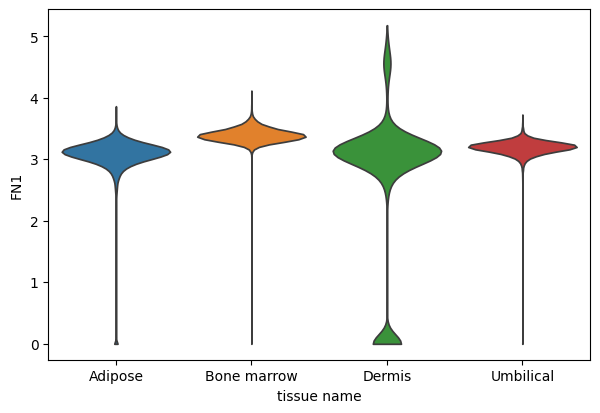


Detailed marker statistics for FN1 in each tissue group:

--- Tissue: Adipose ---
     names  logfoldchanges  pvals_adj      scores
2958   FN1       -0.108499        0.0 -153.147232

--- Tissue: Bone marrow ---
  names  logfoldchanges  pvals_adj      scores
2   FN1        0.559446        0.0  249.020126

--- Tissue: Dermis ---
     names  logfoldchanges  pvals_adj     scores
2801   FN1        -0.67723        0.0 -86.853889

--- Tissue: Umbilical ---
     names  logfoldchanges     pvals_adj  scores
2367   FN1        0.124115  4.012602e-17 -8.5314


In [37]:
# --- 4c. Directly Inspecting a Ubiquitous Marker Gene ---

# 1. Visualize the distribution of FN1 expression across tissues
# A violin plot is perfect for showing both the shape of the distribution and the median/mean.
print("Distribution of FN1 expression across tissues:")
sc.pl.violin(adata, keys='FN1', groupby='tissue_name', stripplot=False)

# 2. Inspect the exact statistics Scanpy calculated for FN1
# This will show the log-fold change, p-value, and percentage of cells expressing (pts)
# in the target group vs. the rest.
print("\nDetailed marker statistics for FN1 in each tissue group:")
if 'rank_genes_groups_tissue' in adata.uns:
    for group in adata.obs['tissue_name'].cat.categories:
        # Retrieve the full stats table for the current group
        stats_df = sc.get.rank_genes_groups_df(adata, group=group, key='rank_genes_groups_tissue')
        
        # Find the row for the gene 'FN1'
        fn1_stats = stats_df[stats_df['names'] == 'FN1']
        
        if not fn1_stats.empty:
            print(f"\n--- Tissue: {group} ---")
            # Define the columns we want, and then filter by what's available
            desired_cols = ['names', 'logfoldchanges', 'pvals_adj', 'scores', 'pts', 'pts_rest']
            available_cols = [col for col in desired_cols if col in fn1_stats.columns]
            print(fn1_stats[available_cols])
        else:
            print(f"\n--- Tissue: {group} ---")
            print("FN1 was not found in the marker list for this group.")
else:
    print("Marker gene analysis for tissue has not been run. Please run the tissue marker analysis cell first.")

Cluster → Label mapping:
  0: MSC: Osteo-primed
  1: MSC: Osteo-primed
  2: MSC: Osteo-primed
  3: Contam: Hematopoietic
  4: Contam: Hematopoietic
  5: Contam: Epithelial / Contam: Neuronal
  6: Contam: Epithelial / Contam: Neuronal
  7: Contam: Hematopoietic
  8: Unknown
  9: MSC: Adipo-primed
  10: MSC: Perivascular/SMC-like
  11: MSC: ECM-high
  12: Contam: Hematopoietic
  13: MSC: Perivascular/SMC-like
  14: Contam: Epithelial / Contam: Neuronal
  15: Contam: Hematopoietic
  16: Contam: Hematopoietic
  17: Contam: Epithelial / Contam: Neuronal


<Figure size 1000x800 with 0 Axes>

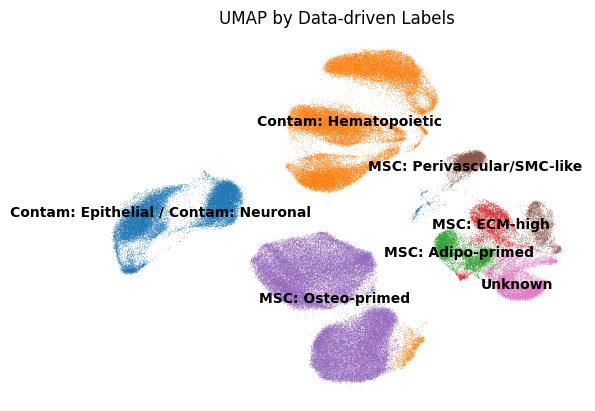

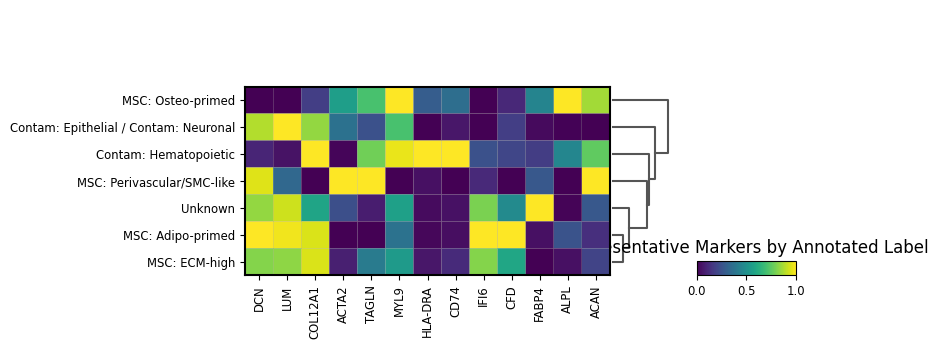

In [34]:
# --- 5. Data-driven Manual Annotation via Gene-set Scoring ---
if 'adata' in locals():
    import numpy as np
    import pandas as pd

    # 1) Define signatures (use combos, not single genes)
    sigs = {
        "MSC: ECM-high": ["DCN","LUM","COL12A1","FN1","FBN1","MFAP5","ITGBL1","ABI3BP","TINAGL1","CDH11"],
        "MSC: Perivascular/SMC-like": ["ACTA2","TAGLN","TAGLN2","MYL9","LMOD1","MYLK","PPP1R14A","PDGFRB","MCAM"],
        "MSC: IFN-licensed/APC-like": ["HLA-DRA","HLA-DPA1","HLA-DPB1","HLA-DMA","CD74","IFI6","IFI27"],
        "MSC: Adipo-primed": ["CFD","PPARG","FABP4","PLIN1","LEPR"],
        "MSC: Osteo-primed": ["RUNX2","SP7","ALPL","BGLAP","SPP1"],
        "MSC: Chondro-primed": ["SOX9","COL2A1","ACAN"],

        # overlays / filters
        "Overlay: Cycling": ["MKI67","TOP2A","NUSAP1","CENPF","UBE2C","TPX2","PRC1","RRM2"],

        # contamination screens (higher priority if strongly positive)
        "Contam: Epithelial": ["KRT7","KRT8","KRT18","CRABP2","EPCAM"],
        "Contam: Hematopoietic": ["PTPRC","LYZ","SRGN","ARHGDIB","MS4A1","CD14"],
        "Contam: Neuronal": ["UCHL1"]
    }

    # keep only genes present
    sigs = {k: [g for g in v if g in adata.var_names] for k, v in sigs.items() if any(g in adata.var_names for g in v)}

    # 2) Score each signature per cell (composite, not single genes)
    for name, genes in sigs.items():
        sc.tl.score_genes(adata, gene_list=genes, score_name=f"score_{name}", use_raw=False)

    # 3) Summarize per-cluster means of scores
    score_cols = [c for c in adata.obs.columns if c.startswith("score_")]
    cluster_means = adata.obs.groupby('leiden_clusters')[score_cols].mean()

    # 4) Z-normalize scores per signature across clusters (so labels are relative-specific)
    z = (cluster_means - cluster_means.mean(axis=0)) / (cluster_means.std(axis=0).replace(0, np.nan))

    # 5) Also require co-expression: fraction of genes in a signature expressed per cluster
    def frac_expressing(genes):
        df = sc.get.obs_df(adata, keys=genes + ['leiden_clusters'])
        # fraction of nonzero per gene, then average across genes
        return (df[genes] > 0).groupby(df['leiden_clusters']).mean().mean(axis=1)

    frac = pd.DataFrame(index=cluster_means.index)
    for name, genes in sigs.items():
        try:
            frac[f"frac_{name}"] = frac_expressing(genes)
        except Exception:
            pass

    # 6) Decide labels with thresholds
    main_sigs = [k for k in sigs if k.startswith("MSC:")]
    contam_sigs = [k for k in sigs if k.startswith("Contam:")]
    cycling_sig = "Overlay: Cycling"

    z_thresh = 0.5         # relative enrichment threshold
    frac_thresh = 0.20     # at least 20% of cells express signature genes on avg

    labels = {}
    for cl in cluster_means.index:
        # contamination check first (priority)
        contam_hits = []
        for cs in contam_sigs:
            z_val = z.loc[cl, f"score_{cs}"] if f"score_{cs}" in z.columns else -np.inf
            f_val = frac.loc[cl, f"frac_{cs}"] if f"frac_{cs}" in frac.columns else 0.0
            if (z_val >= z_thresh and f_val >= 0.10):  # more lenient frac for screens
                contam_hits.append(cs)
        if contam_hits:
            labels[cl] = " / ".join(contam_hits)  # e.g., "Contam: Hematopoietic"
            continue

        # pick best MSC program
        best_name, best_z = None, -np.inf
        for ms in main_sigs:
            z_val = z.loc[cl, f"score_{ms}"] if f"score_{ms}" in z.columns else -np.inf
            f_val = frac.loc[cl, f"frac_{ms}"] if f"frac_{ms}" in frac.columns else 0.0
            if z_val > best_z and f_val >= frac_thresh:
                best_name, best_z = ms, z_val

        label = best_name if (best_name is not None and best_z >= z_thresh) else "Unknown"

        # cycling overlay (suffix)
        if f"score_{cycling_sig}" in z.columns:
            if z.loc[cl, f"score_{cycling_sig}"] >= 0.7:  # stricter for cycling
                label = f"{label} (Cycling)" if label != "Unknown" else "Cycling"

        labels[cl] = label

    # 7) Apply to cells
    adata.obs['cluster_label'] = adata.obs['leiden_clusters'].map(labels).astype('category')

    # 8) Show mapping and quick QC print
    print("Cluster → Label mapping:")
    for k, v in labels.items():
        print(f"  {k}: {v}")

    # 9) Visualizations
    plt.figure(figsize=(10, 8))
    sc.pl.umap(adata, color='cluster_label', title='UMAP by Data-driven Labels',
               legend_loc='on data', frameon=False, show=False)
    plt.show()

    # 10) Matrixplot of representative markers per label
    # choose 3 representative genes per non-contam label (present in data)
    rep = {
        "MSC: ECM-high": ["DCN","LUM","COL12A1"],
        "MSC: Perivascular/SMC-like": ["ACTA2","TAGLN","MYL9"],
        "MSC: IFN-licensed/APC-like": ["HLA-DRA","CD74","IFI6"],
        "MSC: Adipo-primed": ["CFD","PPARG","FABP4"],
        "MSC: Osteo-primed": ["RUNX2","ALPL","SPP1"],
        "MSC: Chondro-primed": ["SOX9","COL2A1","ACAN"],
    }
    gene_list = []
    for k, genes in rep.items():
        gene_list.extend([g for g in genes if g in adata.var_names])
    gene_list = list(dict.fromkeys(gene_list))  # unique, keep order

    if gene_list:
        # Re-calculate the dendrogram for the new cluster labels before plotting
        sc.tl.dendrogram(adata, groupby='cluster_label')
        sc.pl.matrixplot(adata, var_names=gene_list, groupby='cluster_label',
                         dendrogram=True, standard_scale='var', show=False)
        plt.title('Representative Markers by Annotated Label')
        plt.show()
    else:
        print("[warning] None of the representative marker genes were found in var_names.")
